## Section 1: Setup

In [15]:
import numpy as np
from tqdm import tqdm
from scipy.linalg import eigh
from scipy.signal import butter, sosfiltfilt, sosfreqz
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression as LR
import scipy.linalg
import pandas as pd

import mne

## Section 2: Data Import

In [16]:
n_subject = 9

data_dir = './data/'
data_prefix = 'A'
data_suffix = '.npz'
data_type = {'train':'T', 'test':'E'}
data_path = data_dir + data_prefix + '{subject:02d}{type_:s}' + data_suffix

In [17]:
raw_train_subject = []
raw_test_subject = []

for subject_num in range(1, n_subject+1):
    train_path = data_path.format(subject=subject_num, type_=data_type['train'])
    test_path  = data_path.format(subject=subject_num, type_=data_type['test'])
    raw_train_subject.append(np.load(train_path))
    raw_test_subject.append(np.load(test_path))

In [18]:
class_code = {'left':769, 'right':770, 'foot':771, 'tongue':772}

In [19]:
# globally
fs = 250                                    # sampling frequency

# within in each epoch
cue_start = 2.                              # cue starts at
cue_end = 3.25                              # cue ends at
smr_start = 3.                              # smr starts after
smr_end = 6.                                # smr ends after
cue_start_offset = round(cue_start * fs)    # the first cue sample is at 
cue_end_offset   = round(cue_end * fs)      # the last cue sample is at
smr_start_offset = round(smr_start * fs)    # the first smr sample is after
smr_end_offset   = round(smr_end * fs)      # the last smr sample is after

In [20]:
train_subject = []
for raw_data in raw_train_subject: 
    signal = raw_data['s'].T
    cue_class = raw_data['etyp']
    cue_position = raw_data['epos']
    
    X_train = {}
    
    for name, code in class_code.items():
        epoch_start = cue_position[cue_class==code] - cue_start_offset
        
        epochs = []
        for i in range(len(epoch_start)):
            epochs.append(signal[:, epoch_start[i]+smr_start_offset:epoch_start[i]+smr_end_offset])
        epochs = np.stack(epochs)
        
        X_train[name] = epochs
    
    train_subject.append(X_train)

In [21]:
test_subject = []
for raw_data in raw_test_subject: 
    signal = raw_data['s'].T
    cue_class = raw_data['etyp']
    cue_position = raw_data['epos']
    
    X_test = {}
    
    name = 'unknown'
    code = 783
    
    epoch_start = cue_position[cue_class==code] - cue_start_offset

    epochs = []
    for i in range(len(epoch_start)):
        epochs.append(signal[:, epoch_start[i]+smr_start_offset:epoch_start[i]+smr_end_offset])
    epochs = np.stack(epochs)

    X_test[name] = epochs
    
    test_subject.append(X_test)

In [22]:
train_subject[0]['left']

array([[[ -0.24414062,   3.17382812,   0.        , ...,  -9.32617188,
          -7.12890625, -14.50195312],
        [  4.58984375,   2.9296875 ,  -0.87890625, ..., -12.15820312,
         -11.62109375, -16.69921875],
        [ -0.73242188,   1.61132812,  -1.85546875, ..., -10.7421875 ,
          -9.32617188, -16.2109375 ],
        ...,
        [  4.8828125 ,   8.30078125,   6.34765625, ...,   2.9296875 ,
           4.8828125 ,   2.44140625],
        [  0.9765625 ,   6.34765625,   3.90625   , ...,   8.30078125,
           3.90625   ,  -2.9296875 ],
        [  7.32421875,   6.34765625,   7.8125    , ...,  -0.48828125,
           3.41796875,  -4.8828125 ]],

       [[-11.1328125 ,  -6.93359375,  -1.61132812, ...,   4.54101562,
           1.51367188,   1.02539062],
        [-12.5       ,  -7.76367188,  -2.97851562, ...,  -1.31835938,
          -2.97851562,  -1.7578125 ],
        [-11.37695312,  -3.80859375,   2.734375  , ...,   3.27148438,
           0.43945312,  -0.5859375 ],
        ...,


## Section 3: Data Processing

In [23]:
fs = 250
lowcut = 9
highcut = 14

chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5','C3','C1','Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
n_channels = len(chs)

In [24]:
def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y

In [25]:
for i in tqdm(range(len(train_subject))):
    for key in train_subject[i]:
        X_bandpass = np.apply_along_axis(butter_bandpass_filter, 2, train_subject[i][key][:,:n_channels,:], lowcut, highcut, fs, 4)
        T = X_bandpass.shape[2]
        #X = (X_bandpass / np.sqrt(T)) @ (np.identity(T) - np.ones((T,T)))
        train_subject[i][key] = X_bandpass - np.tile( X_bandpass.mean(axis=2).reshape(X_bandpass.shape[0],X_bandpass.shape[1], 1), X_bandpass.shape[2]) 

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:51<00:00,  5.67s/it]


In [26]:
train_subject[0]['left'][0][0]

array([ 7.72395266e-01,  3.49922644e-01, -7.86993371e-02, -4.74499373e-01,
       -8.05784300e-01, -1.05112459e+00, -1.20078569e+00, -1.25649685e+00,
       -1.22968125e+00, -1.13848217e+00, -1.00408031e+00, -8.46886306e-01,
       -6.83196909e-01, -5.22824115e-01, -3.68054000e-01, -2.14087879e-01,
       -5.08912554e-02,  1.33842342e-01,  3.51083817e-01,  6.06801121e-01,
        8.98845922e-01,  1.21495006e+00,  1.53224773e+00,  1.81853566e+00,
        2.03524265e+00,  2.14183393e+00,  2.10115778e+00,  1.88508115e+00,
        1.47968024e+00,  8.89262917e-01,  1.38604417e-01, -7.27036877e-01,
       -1.64430922e+00, -2.53646989e+00, -3.32002890e+00, -3.91271804e+00,
       -4.24198783e+00, -4.25313786e+00, -3.91618648e+00, -3.23068518e+00,
       -2.22787166e+00, -9.69814482e-01,  4.54496190e-01,  1.93584485e+00,
        3.35371693e+00,  4.58666097e+00,  5.52313322e+00,  6.07180573e+00,
        6.17035439e+00,  5.79187564e+00,  4.94829657e+00,  3.69042098e+00,
        2.10456584e+00,  

## Section 4: Data Selection

In [27]:
subject_num = 0
class_pos = 'left'
class_neg = 'tongue'
train_test_ratio = 0.8

In [28]:
def select_data(subject_num):
    X_pos = train_subject[subject_num][class_pos]
    X_neg = train_subject[subject_num][class_neg]

    np.random.shuffle(X_pos)
    np.random.shuffle(X_neg)

    X_test_pos = X_pos[int(len(X_pos) * train_test_ratio):, :, :]
    X_test_neg = X_neg[int(len(X_neg) * train_test_ratio):, :, :]

    X_train_pos = X_pos[:int(len(X_pos) * train_test_ratio), :, :]
    X_train_neg = X_neg[:int(len(X_neg) * train_test_ratio), :, :]

    X_train = np.concatenate((X_train_pos, X_train_neg), axis=0)
    y_train = np.concatenate((np.ones(X_train_pos.shape[0]), -np.ones(X_train_neg.shape[0])), axis=0)

    X_test = np.concatenate((X_test_pos, X_test_neg), axis=0)
    y_test = np.concatenate((np.ones(X_test_pos.shape[0]), -np.ones(X_test_neg.shape[0])), axis=0)

    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)
    return X_train, y_train, X_test, y_test, X_train_pos, X_train_neg

## Section 5: Common Spatial Pattern

In [29]:
def compute_covariance_matrix(X):
    return np.sum(X @ X.transpose((0,2,1)), axis=0) / X.shape[0]

def compute_spatial_filters(S1, S2):
    return scipy.linalg.eigh(S1, S1+S2)

In [30]:
def compute_csp(X_train_pos, X_train_neg):
    S1 = compute_covariance_matrix(X_train_pos)
    S2 = compute_covariance_matrix(X_train_neg)
    L, W = compute_spatial_filters(S1, S2)
    A = np.linalg.inv(W).T
    return L, W, A

In [31]:
def plot_csp(W,A):
    inter1020_montage = mne.channels.make_standard_montage('standard_1020')
    ch_pos = inter1020_montage.get_positions()['ch_pos']
    pos = np.stack([ch_pos[ch] for ch in chs])[:,:2]
    
    fig, ax = plt.subplots(2, 2)
    mne.viz.plot_topomap(W[:, 0], pos, axes=ax[0,0], show=False)
    mne.viz.plot_topomap(A[:, 0], pos, axes=ax[0,1], show=False)
    mne.viz.plot_topomap(W[:, -1], pos, axes=ax[1,0], show=False)
    mne.viz.plot_topomap(A[:, -1], pos, axes=ax[1,1], show=False)

## Section 6: Linear Discriminant Analysis

In [32]:
J = 6

In [33]:
def Process_w(w, j):
    processed_w = np.hstack((w[:,:int(j/2.)],w[:,-int(j/2.):]))
                            
    return processed_w

In [34]:
def filter_input(data, w, j):
    processed_data = []
    for k in range(data.shape[0]):
        processed_data_temp = [1]
        for i in range(0,j):
            temp_data = np.log(w[:,i].T @ data[k,:,:] @ data[k,:,:].T @ w[:,i])
            processed_data_temp.append(temp_data)
        processed_data.append(np.array(processed_data_temp))
    return np.vstack(processed_data)

In [35]:
def CSPFilter(data, w, label, j):
    w = np.array(w)
    data = np.array(data)
    model = LDA()
    processed_data = filter_input(data, w, j)
    model.fit(processed_data,label)
    return model

In [36]:
def compute_score(X_train, y_train, X_test, y_test, W):
    W_ = Process_w(W, J)
    model = CSPFilter(X_train, W_, y_train, J)
    return model.score(filter_input(X_test, W_, J), y_test)

## Section 7: Accuracy

C:\Users\23176\AppData\Local\Temp/ipykernel_8652/2740171885.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(2, 2)


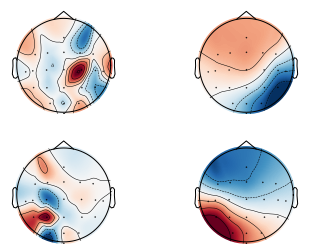

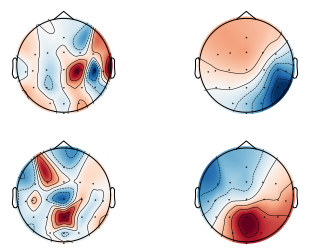

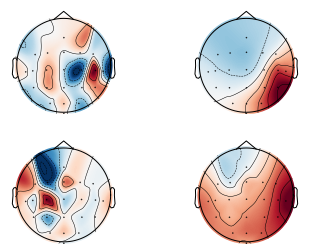

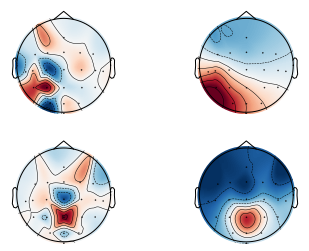

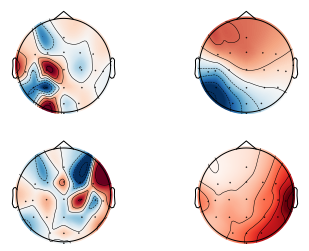

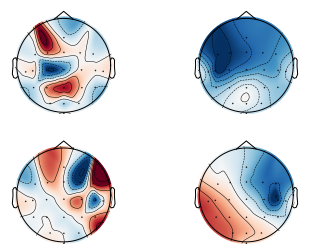

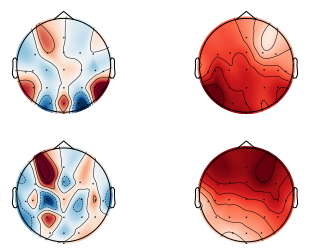

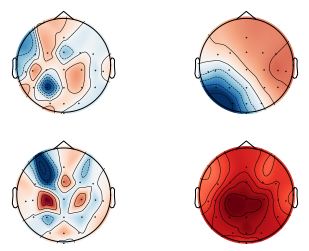

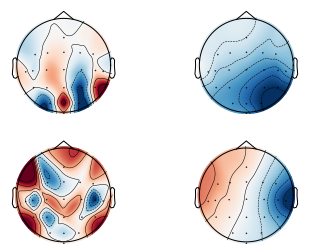

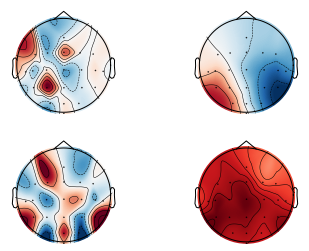

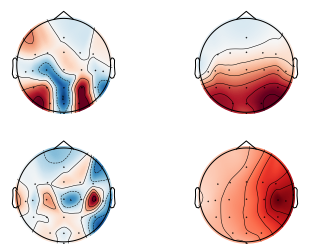

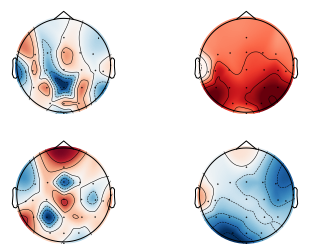

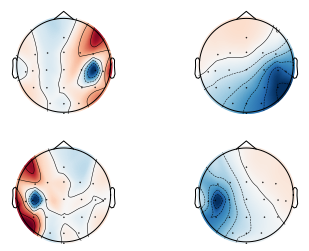

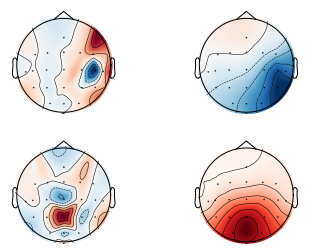

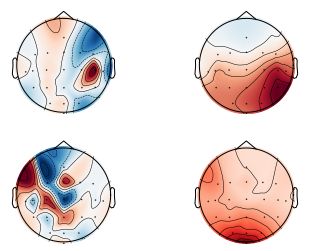

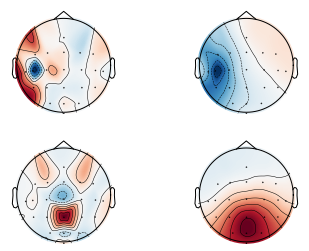

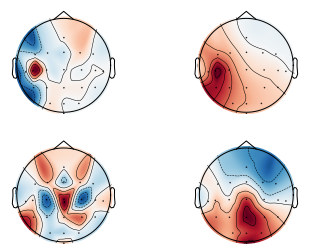

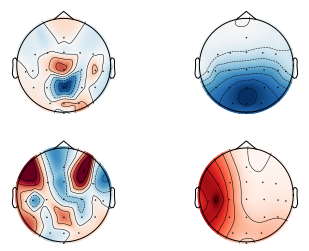

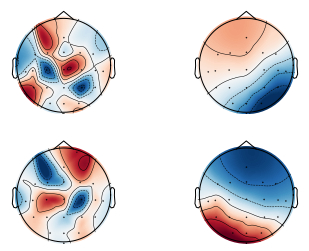

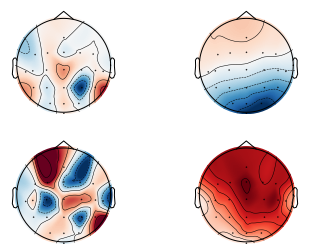

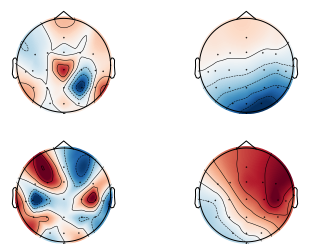

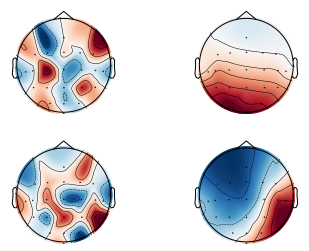

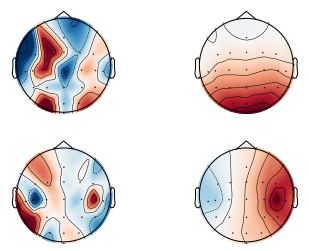

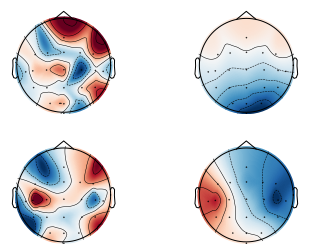

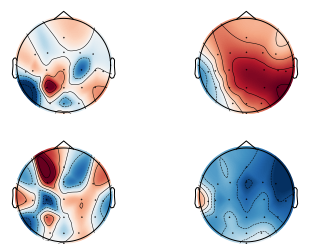

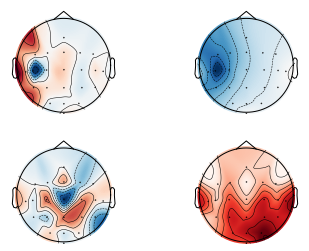

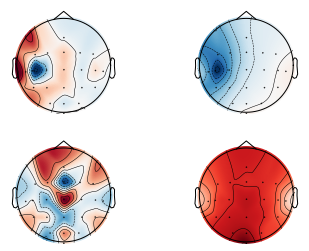

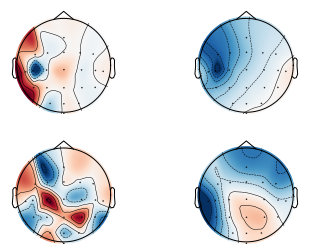

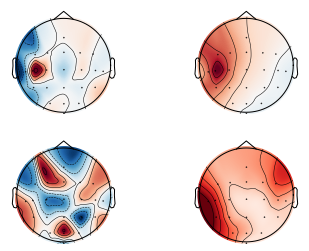

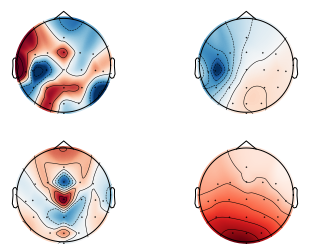

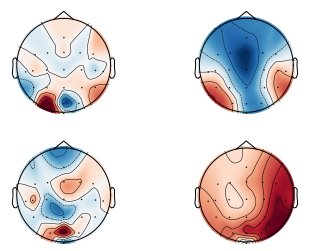

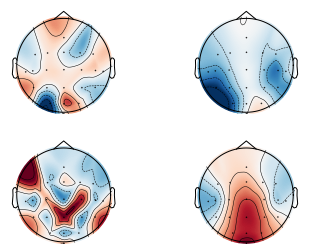

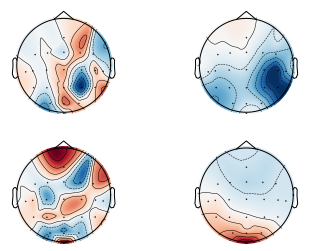

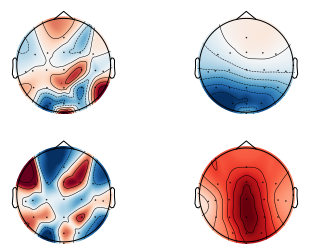

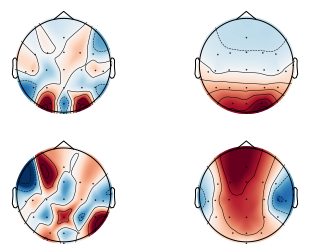

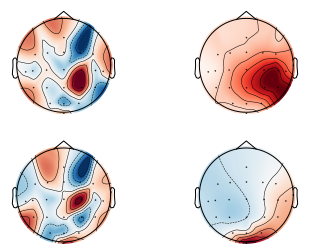

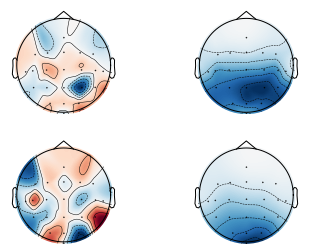

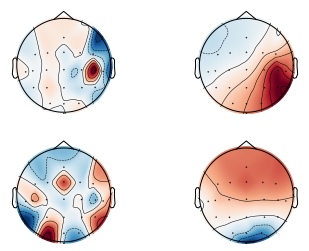

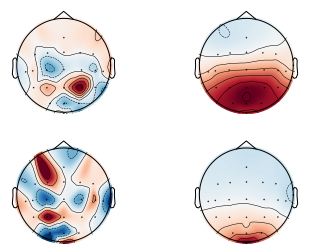

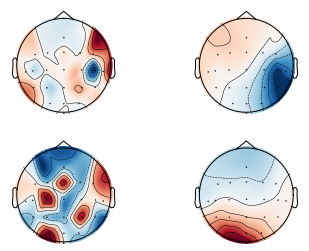

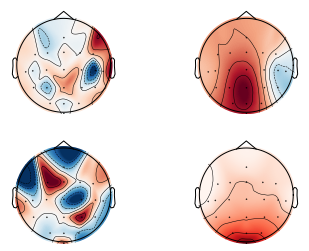

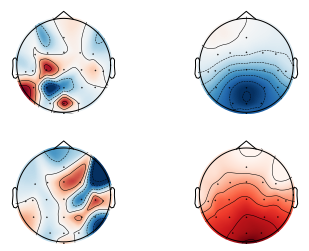

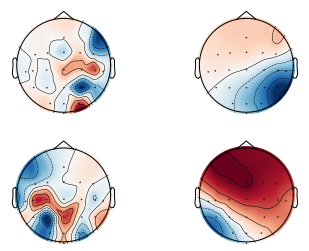

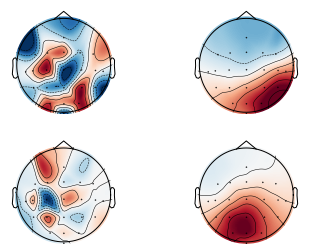

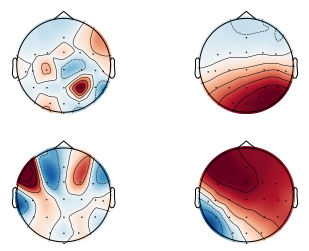

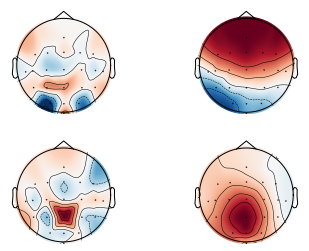

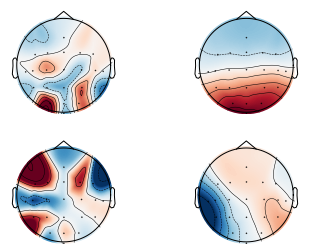

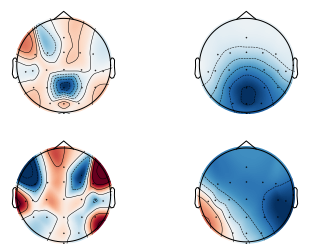

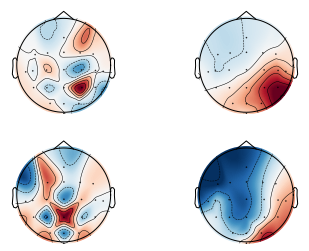

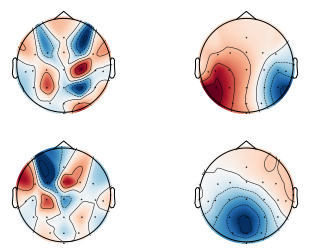

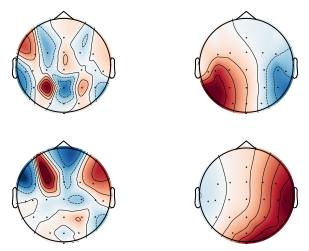

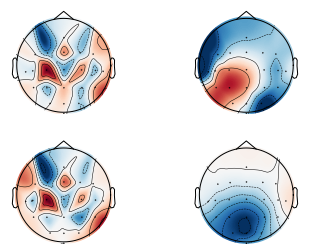

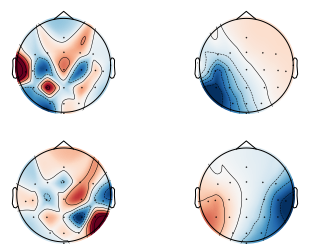

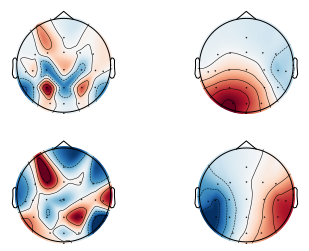

In [37]:
classes = [ 
    ('left','right'),
    ('left','foot'),
    ('left','tongue'),
    ('right','foot'),
    ('right','tongue'), 
    ('foot','tongue')
]
accuracy_table = np.empty((len(train_subject), 6))
for subject_num in range(len(train_subject)):
    for i in range(6):
        class_pos = classes[i][0]
        class_neg = classes[i][1]
        X_train, y_train, X_test, y_test, X_train_pos, X_train_neg = select_data(subject_num)
        L, W, A = compute_csp(X_train_pos, X_train_neg)
        plot_csp(W,A)
        accuracy_table[subject_num][i] = compute_score(X_train, y_train, X_test, y_test, W)

In [38]:
accuracy_table = pd.DataFrame(accuracy_table, columns=classes)

In [39]:
accuracy_table

(left, right)  (left, foot)  (left, tongue)  (right, foot)  \
0       0.700000      0.900000        0.933333       0.933333   
1       0.600000      0.733333        0.700000       0.600000   
2       0.933333      0.933333        0.966667       0.966667   
3       0.633333      0.600000        0.866667       0.666667   
4       0.700000      0.600000        0.600000       0.666667   
5       0.766667      0.533333        0.766667       0.566667   
6       0.633333      0.833333        0.966667       0.833333   
7       0.966667      0.933333        0.900000       0.933333   
8       0.833333      0.800000        0.966667       0.633333   

   (right, tongue)  (foot, tongue)  
0         1.000000        0.866667  
1         0.666667        0.566667  
2         0.866667        0.866667  
3         0.633333        0.700000  
4         0.466667        0.666667  
5         0.633333        0.566667  
6         0.933333        0.866667  
7         0.933333        0.900000  
8         0.733333        0.766667